# Using GRASS for stream-network extraction and basins delineation in Colab
Methodological procedure described in:

Amatulli, Giuseppe, et al. [Hydrography90m: A new high-resolution global hydrographic dataset.](https://essd.copernicus.org/articles/14/4525/2022/) Earth System Science Data Discussions 2022 (2022): 1-43.




## Install python libraryes and softwares

In [1]:
! pip install rasterio
! pip install geopandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 37.6 MB/s eta 0:00:00


In [28]:
! lss


/bin/bash: line 1: lss: command not found


In [2]:
%%bash
apt install gdal-bin python3-gdal grass grass-dev pktools

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  fonts-dejavu-core fonts-droid-fallback fonts-lyx fonts-noto-mono
  fonts-urw-base35 ghostscript grass-core grass-doc grass-gui libalgorithms1
  libfann2 libfftw3-double3 libfileclasses1 libglu1-mesa libgs9 libgs9-common
  libgsl27 libgslcblas0 libidn12 libijs-0.35 libimageclasses1 libimagequant0
  libjbig2dec0 liblbfgsb0 libnotify4 libpdal-plugin-e57 libpdal-plugin-faux
  libpdal-plugin-hdf libpdal-plugin-icebridge libpdal-plugin-pgpointcloud
  libpdal-plugins libpdal16 libraqm0 libwxbase3.2-1 libwxgtk-gl3.2-1
  libwxgtk3.2-1 libxsimd-dev libxtst6 libxxf86dga1 poppler-data proj-bin
  python-matplotlib-data python3-appdirs python3-attr python3-beniget
  python3-brotli python3-bs4 python3-chardet python3-cycler python3-dateutil
  python3-decorator python3-fonttools python3-fs python3-gast python3-html5lib
  python3-kiwisolver python3-lxml python3-lz4 py

## Theoretical background
The first step towards modeling hydrological features is delineating a comprehensive hydrography network. DEMs at different spatial resolutions allow for the identification of stream channels, using a variety of flow-routing algorithms. Such algorithms are based on the observation that water follows the steepest and shortest route along a relief, and accumulates in valleys, lowlands, flat areas and depressions. Several algorithms have been proposed for stream network routing. These algorithms proceed in several stages: determining flow directions, resolving depressions and flat areas, and finally, calculating flow accumulation.

## Flow accumulation

Flow accumulation refers to the process of accumulating the flow of water across a terrain, often used in GIS to model drainage patterns and identify streams. Single flow direction (SFD) assumes water flows in only one direction, while multi-flow direction (MFD) allows water to flow in multiple directions, potentially more accurately representing terrain features.

In [3]:
from IPython.display import display, HTML

display(HTML('<img src="https://github.com/selvaje/SE_docs/blob/master/source/images/flowaccumulation_algorithm.png?raw=true" width="1000">'))

## Methodology
Below we describe how we will extract a new high-resolution hydrography (stream-network and basins) from the 1KM DEM. In this exercise we simulate a case that we can not run the full South America continent in one tile because we reach RAM limitation. Therefore we compute the analysis in 3 tiles and then we combine the results.

We are going to use 3 GRASS commands:
* [r.watershed](https://grass.osgeo.org/grass-stable/manuals/r.watershed.html)  to derive flow accumulation
* [r.stream.extract](https://grass.osgeo.org/grass-stable/manuals/r.stream.extract.html) to extract-stream network
* [r.stream.basins](https://grass.osgeo.org/grass-stable/manuals/addons/r.stream.basins.html) to delineate basins

## Download the input dataset

In [29]:
# mask sea-land
!wget -O SA_msk.tif https://raw.githubusercontent.com/selvaje/SE_data/53a02ab19e45d1a16cbc63ad5fb30da4ae67839f/exercise/geodata/dem/SA_msk_1km.tif
# area for each pixel in km2
!wget -O SA_area.tif https://raw.githubusercontent.com/selvaje/SE_data/b21ed1b52e67f2633cb9a685c8cae9422ec42948/exercise/geodata/dem/SA_are_1km_msk.tif
# elevation
!wget -O SA_elevation.tif https://raw.githubusercontent.com/selvaje/SE_data/b21ed1b52e67f2633cb9a685c8cae9422ec42948/exercise/geodata/dem/SA_elevation_mn_GMTED2010_mn_msk.tif
# depresssion
!wget -O SA_dep.tif https://raw.githubusercontent.com/selvaje/SE_data/66617b33f3704a532d9fc0f39953235ce43cd5b1/exercise/geodata/dem/SA_all_dep_1km.tif
# computation tiles
!wget -O tilesComp.gpkg https://raw.githubusercontent.com/selvaje/SE_data/66617b33f3704a532d9fc0f39953235ce43cd5b1/exercise/geodata/dem/tilesComp.gpkg

--2025-06-13 09:21:50--  https://raw.githubusercontent.com/selvaje/SE_data/53a02ab19e45d1a16cbc63ad5fb30da4ae67839f/exercise/geodata/dem/SA_msk_1km.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 389386 (380K) [image/tiff]
Saving to: ‘SA_msk.tif’

SA_msk.tif          100%[===================>] 380.26K  --.-KB/s    in 0.03s   

2025-06-13 09:21:50 (12.4 MB/s) - ‘SA_msk.tif’ saved [389386/389386]

--2025-06-13 09:21:50--  https://raw.githubusercontent.com/selvaje/SE_data/b21ed1b52e67f2633cb9a685c8cae9422ec42948/exercise/geodata/dem/SA_are_1km_msk.tif
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:44

In [30]:
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
import geopandas as gpd

## Plotting the input dataset

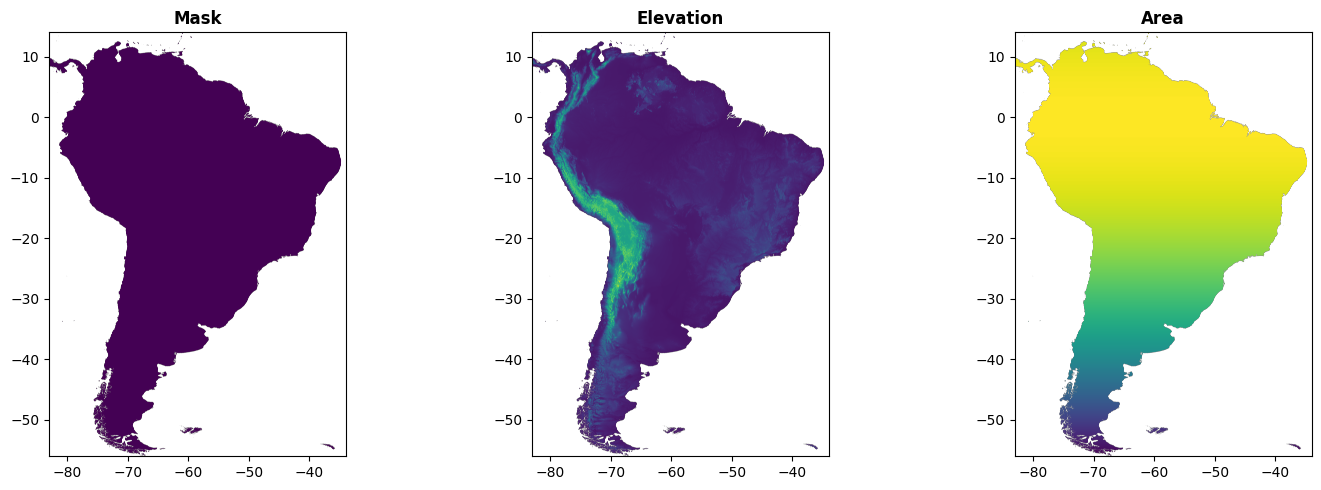

In [31]:
# Open raster datasets

msk = rasterio.open("/content/SA_msk.tif")
dem = rasterio.open("/content/SA_elevation.tif")
area = rasterio.open("/content/SA_area.tif")

# Create a figure and subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot each raster on a subplot
show(msk, ax=ax1, title="Mask")
show(dem, ax=ax2, title="Elevation")
show(area, ax=ax3, title="Area")

# Adjust layout and display
plt.tight_layout()
plt.show()

## Plotting the elevation and the computational tiles

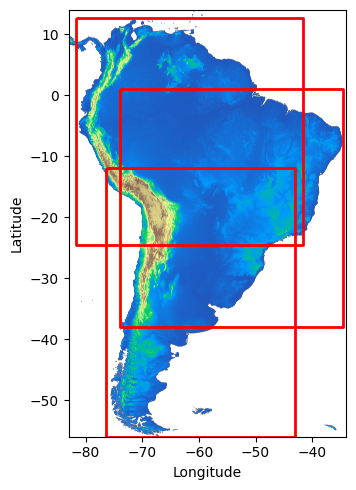

In [7]:
# Open raster datasets
dem = rasterio.open("/content/SA_elevation.tif")

# Open the vector dataset
tiles = gpd.read_file("/content/tilesComp.gpkg")

# Create a figure and an axes
fig, ax = plt.subplots(figsize=(5, 5))

# Plot the DEM raster
show(dem, ax=ax, cmap='terrain') # Use a terrain colormap

# Plot the vector data on top of the DEM
tiles.boundary.plot(ax=ax, color="red", linewidth=2, alpha=1) # Plot the boundaries in red
tiles.plot(ax=ax, alpha=0.5, color='none', edgecolor='red') # Transparent fill with red outline


# Add a title and labels
# ax.set_title("DEM with Irregular Tiling System Overlay")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")


plt.tight_layout()
plt.show()


## Install the grass add-on

In [8]:
%%bash
grass --exec g.extension extension=r.stream.basins

Your branch is up to date with 'origin/grass8'.


Fetching <r.stream.basins> from <https://github.com/OSGeo/grass-addons/>
(be patient)...
Already on 'grass8'
Compiling...
Installing...
Updating extensions metadata file...
Updating extension modules metadata file...
Installation of <r.stream.basins> successfully finished


## Compute continental seamless flow accumulation

In [26]:
%%bash

cd /content/

# use -c create loctation/project to using the SA_elevation.tif file as reference
rm -fr /content/hydrographySA_1
grass --text -c  /content/SA_elevation.tif /content/hydrographySA_1  --exec <<'EOF'

g.gisenv set="GRASS_VERBOSE=-1","DEBUG=0"

## import the layers
r.external input=/content/SA_elevation.tif             output=elv --o --q # dem
r.external input=/content/SA_dep.tif                   output=dep --o --q # depression
r.external input=/content/SA_area.tif                  output=are --o --q # area-pixel
r.external input=/content/SA_msk.tif                   output=msk --o --q # land-ocean mask

g.region  -m

for tile in 1 2 3  ; do     # loop for each tile
r.mask raster=msk --o --q   # usefull to mask the flow accumulation

# extract tile extent from the  tilesComp.gpkg
wL=$(ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $2 }')
nL=$(ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $3 }')
eL=$(ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $4 }')
sL=$(ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $7 }')

g.region w=$wL  n=$nL  s=$sL  e=$eL  res=0:00:30   --o
g.region -m

### maximum ram 66571M  for 2^31 -1   (2 147 483 647 cell)  / 1 000 000  * 31 M
####  -m  Enable disk swap memory option: Operation is slow
####  -b Beautify flat areas
####   threshold=8  8 km2

echo "############# compute the flow accumulation using MFD for tile $tile ##############"
r.watershed  -b  elevation=elv  depression=dep  accumulation=flow drainage=dir_rw flow=are   memory=4000 --o --q

echo "############# extract stream ##################"
r.stream.extract elevation=elv accumulation=flow depression=dep threshold=8 direction=dir_rs stream_raster=stream  memory=2000 --o --q

echo "############# delineate basin  ##################"
r.stream.basins -l  stream_rast=stream direction=dir_rs   basins=lbasin  memory=2000 --o  --q
r.colors -r stream --q ; r.colors -r lbasin --q ; r.colors -r flow --q

r.out.gdal --o -c -m  createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=lbasin output=/content/lbasinTmp1_$tile.tif

echo "###### create a small zone flow binary for later use ###########"
r.mapcalc " small_zone_flow =   if( !isnull(flow) && isnull(lbasin) , 1 , null()) " --o  --q

echo "##### create a smaller box ########"
CropW=$( ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep " CropW" | awk '{print $4 }')
CropE=$( ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep " CropE" | awk '{print $4 }')
CropS=$( ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep " CropS" | awk '{print $4 }')
CropN=$( ogrinfo -al -where  "id  = '$tile'" /content/tilesComp.gpkg | grep " CropN" | awk '{print $4 }')

nS=$(g.region -m  | grep ^n= | awk -F "=" -v CropN=$CropN  '{ printf ("%.14f\n" , $2 - CropN ) }' )
sS=$(g.region -m  | grep ^s= | awk -F "=" -v CropS=$CropS  '{ printf ("%.14f\n" , $2 + CropS ) }' )
eS=$(g.region -m  | grep ^e= | awk -F "=" -v CropE=$CropE  '{ printf ("%.14f\n" , $2 - CropE ) }' )
wS=$(g.region -m  | grep ^w= | awk -F "=" -v CropW=$CropW  '{ printf ("%.14f\n" , $2 + CropW ) }' )

# set a smaller region to avoid border effect
g.region w=$wS  n=$nS  s=$sS  e=$eS  res=0:00:30  save=smallext --o  --q # smaller region
g.region region=smallext --o --q
g.region  -m

# at this point we want remove all no-entire basins. To do this we create 4 stripes of 1 pixel allong the tile borders.

echo "######## left stripe ########"
eST=$(g.region -m  | grep ^e= | awk -F "=" '{ print $2 }')
wST=$(g.region -m  | grep ^e= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS     e=$eST w=$wST  res=0:00:30 --o
r.mapcalc " lbasin_wstripe = lbasin " --o --q
g.region region=smallext --o --q

echo "######## right stripe  ########"
wST=$(g.region -m  | grep ^w= | awk -F "=" '{ print $2   }' )
eST=$(g.region -m  | grep ^w= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS  e=$eST w=$wST  res=0:00:30 --o
r.mapcalc " lbasin_estripe    = lbasin " --o --q

g.region region=smallext --o --q
echo "######## top stripe   ########"
nST=$(g.region -m  | grep ^n= | awk -F "=" '{ print $2   }' )
sST=$(g.region -m  | grep ^n= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region e=$eS w=$wS n=$nST s=$sST res=0:00:30  --o
r.mapcalc " lbasin_nstripe    = lbasin " --o --q
g.region region=smallext --o --q

echo "######## bottom stripe ########"
sST=$(g.region -m  | grep ^s= | awk -F "=" '{ print $2   }' )
nST=$(g.region -m  | grep ^s= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region   e=$eS  w=$wS  n=$nST  s=$sST  res=0:00:30 --o
r.mapcalc " lbasin_sstripe    = lbasin " --o --q
g.region region=smallext   --o --q

# the 1 pixel strip is used to have the ID of the truncated basin.

echo "######## remove incompleate basins  ########"
    cat <(r.report -n -h units=c map=lbasin_estripe | awk  '{ gsub ("\\|"," " ) ; { print $1 } } ' | awk '$1 ~ /^[0-9]+$/ { print $1 } ') \
        <(r.report -n -h units=c map=lbasin_wstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 } } ' | awk '$1 ~ /^[0-9]+$/ { print $1 } ') \
        <(r.report -n -h units=c map=lbasin_sstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 } } ' | awk '$1 ~ /^[0-9]+$/ { print $1 } ') \
        <(r.report -n -h units=c map=lbasin_nstripe | awk  '{ gsub ("\\|"," " ) ; { print $1 } } ' | awk '$1 ~ /^[0-9]+$/ { print $1 } ') \
        <(r.report -n -h units=c map=lbasin         | awk  '{ gsub ("\\|"," " ) ; { print $1 } } ' | awk '$1 ~ /^[0-9]+$/ { print $1 } ') \
      | sort  | uniq -c | awk '{ if($1==1) {print $2"="$2 } else { print $2"=NULL"}  }' >  /content/lbasin_${tile}_reclass.txt

# use the r.reclass command to reclass ID basin to NULL

r.reclass input=lbasin  output=lbasin_rec   rules=/content/lbasin_${tile}_reclass.txt   --o --q
rm -f /content/lbasin_${tile}_reclass.txt

r.mapcalc  " lbasin_clean = lbasin_rec" --o --q
g.remove -f  type=raster name=lbasin_rec,lbasin_estripe,lbasin_wstripe,lbasin_nstripe,lbasin_sstripe --q

echo "############  export basin only for visual inspection  ############"

r.mask raster=lbasin_clean --o --q
r.out.gdal --o -c -m createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=lbasin_clean  output=/content/lbasinTmp2_$tile.tif

echo "############ output the flow accumulation  ############"
r.mask raster=msk --o --q

r.mapcalc  " lbasin_flow_clean  = if ( !isnull(lbasin_clean ) || !isnull(small_zone_flow) , 1 , null()  ) " --o --q
r.grow  input=lbasin_flow_clean  output=lbasin_flow_clean_grow  radius=4  --o --q
r.mask  raster=lbasin_flow_clean_grow   --o --q

r.out.gdal --o -f -c -m createopt="COMPRESS=DEFLATE,ZLEVEL=9"  nodata=-9999999  type=Float32 format=GTiff input=flow output=/content/flow_${tile}.tif

gdal_edit.py -a_ullr  $wS $nS $eS $sS  /content/flow_${tile}.tif
gdal_edit.py -tr 0.00833333333333333333333333333333333 -0.00833333333333333333333333333333333  /content/flow_${tile}.tif

done

EOF


projection=3
zone=0
n=14
s=-56
w=-83
e=-34
nsres=923.44150551
ewres=703.7149865
rows=8400
cols=5880
cells=49392000
projection=3
zone=0
n=-12
s=-56
w=-76.4
e=-43
nsres=924.52244935
ewres=710.89449752
rows=5280
cols=4008
cells=21162240
############# compute the flow accumulation using MFD for tile 1 ##############
############# extract stream ##################
############# delineate basin  ##################
###### create a small zone flow binary for later use ###########
##### create a smaller box ########
projection=3
zone=0
n=-14
s=-56
w=-75.8
e=-45
nsres=924.64630106
ewres=707.62000721
rows=5040
cols=3696
cells=18627840
######## left stripe ########
######## right stripe  ########
######## top stripe   ########
######## bottom stripe ########
######## remove incompleate basins  ########
############  export basin only for visual inspection  ############
############ output the flow accumulation  ############
projection=3
zone=0
n=1
s=-38
w=-73.9
e=-34.6
nsres=922.66504302
ewres=826

Starting GRASS GIS...
Creating new GRASS GIS project <hydrographySA_1>...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
       \____/_/ |_/_/  |_/____/____/   \____/___//____/

Welcome to GRASS GIS 8.4.1
GRASS GIS homepage:                      https://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

Checking GDAL data type and nodata value...
   2%   5%   8%  11%  14%  17%  20%  23%  26%  29%  32%  35%  38%  41%  44%  47%  50%  53

## Merge flow accumulation tiles



In [10]:
%%bash
gdalbuildvrt  -srcnodata -9999999 -vrtnodata -9999999 /content/flow_all.vrt /content/flow_?.tif
gdal_translate -co COMPRESS=DEFLATE -co ZLEVEL=9 /content/flow_all.vrt /content/flow_all.tif

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5616, 8244
0...10...20...30...40...50...60...70...80...90...100 - done.


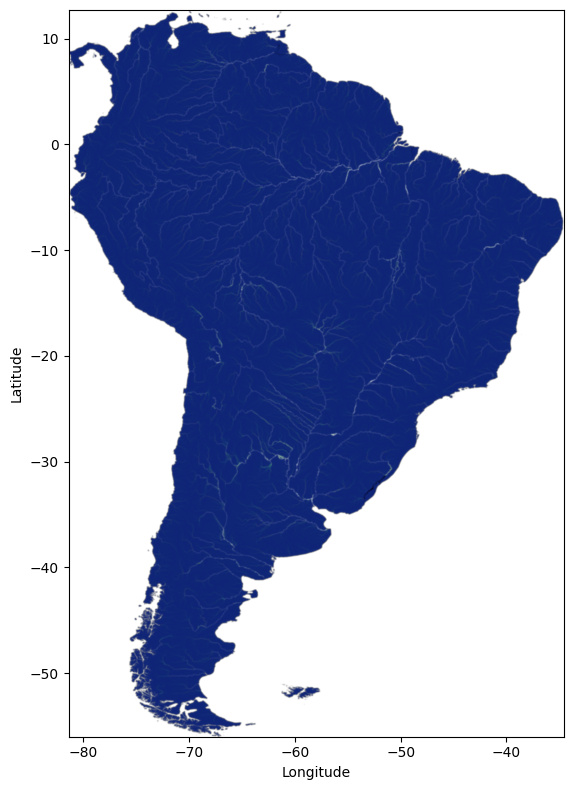

In [11]:
flow = rasterio.open("/content/flow_all.tif")
# Create a figure and an axes
fig, ax = plt.subplots(figsize=(8, 8))
show(flow, ax=ax , cmap='gist_earth', vmin=-2000, vmax=20000 , interpolation='bicubic')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## Compute continental seamless basins and streams  
Redelineate the basin and streams using the same procedure then before but using the continental flow accumulation.

In [12]:
%%bash
rm -fr /content/hydrographySA_2
grass --text -c  /content/flow_all.tif /content/hydrographySA_2  --exec <<'EOF'

## import the layers
r.external input=/content/flow_all.tif                     output=flow --o --q # flow accumulation
r.external input=/content/SA_elevation.tif output=elv  --o --q # dem
r.external input=/content/SA_dep.tif                   output=dep  --o --q # depression
r.external input=/content/SA_msk.tif                   output=msk  --o --q # land-ocean mask

g.region  -m

for tile in 1 2 3  ; do  # loop for each tile
r.mask raster=msk --o # usefull to mask the flow accumulation

wL=$(ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $2 }')
nL=$(ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $3 }')
eL=$(ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $4 }')
sL=$(ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep POLYGON | awk '{ gsub(/[(()),]/," ",$0 ); print $7 }')

g.region w=$wL  n=$nL  s=$sL  e=$eL  res=0:00:30   --o
g.region -m

### maximum ram 66571M  for 2^63 -1   (2 147 483 647 cell)  / 1 000 000  * 31 M
####  -m  Enable disk swap memory option: Operation is slow
####  -b Beautify flat areas
####   threshold=1  = ~1 km2 = 0.9  m2

echo "############# extract stream ##################"
r.stream.extract elevation=elv accumulation=flow depression=dep threshold=8 direction=dir_rs stream_raster=stream  memory=4000 --o --q

echo "############# delineate basin and sub-basin  ##################"
r.stream.basins -l  stream_rast=stream direction=dir_rs   basins=lbasin  memory=2000 --o --q
r.colors -r stream --q; r.colors -r lbasin --q ; r.colors -r flow --q

echo "###### create a small zone flow binary for later use ###########"
r.mapcalc " small_zone_flow =   if( !isnull(flow) && isnull(lbasin) , 1 , null()) " --o --q

echo "##### create a smaller box ########"
CropW=$( ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep " CropW" | awk '{print $4}' )
CropE=$( ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep " CropE" | awk '{print $4}' )
CropS=$( ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep " CropS" | awk '{print $4}' )
CropN=$( ogrinfo -al -where  " id  = '$tile' " /content/tilesComp.gpkg | grep " CropN" | awk '{print $4}' )

nS=$(g.region -m  | grep ^n= | awk -F "=" -v CropN=$CropN  '{ printf ("%.14f\n" , $2 - CropN ) }' )
sS=$(g.region -m  | grep ^s= | awk -F "=" -v CropS=$CropS  '{ printf ("%.14f\n" , $2 + CropS ) }' )
eS=$(g.region -m  | grep ^e= | awk -F "=" -v CropE=$CropE  '{ printf ("%.14f\n" , $2 - CropE ) }' )
wS=$(g.region -m  | grep ^w= | awk -F "=" -v CropW=$CropW  '{ printf ("%.14f\n" , $2 + CropW ) }' )

g.region w=$wS  n=$nS  s=$sS  e=$eS  res=0:00:30  save=smallext --o --q # smaller region
g.region region=smallext --o --q
g.region  -m --q

echo "######## left stripe ########"
eST=$(g.region -m  | grep ^e= | awk -F "=" '{ print $2 }')
wST=$(g.region -m  | grep ^e= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS     e=$eST w=$wST  res=0:00:30 --o --q
r.mapcalc " lbasin_wstripe = lbasin " --o --q
g.region region=smallext --o --q

echo "######## right stripe  ########"
wST=$(g.region -m  | grep ^w= | awk -F "=" '{ print $2   }' )
eST=$(g.region -m  | grep ^w= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region n=$nS s=$sS  e=$eST w=$wST  res=0:00:30 --o --q
r.mapcalc " lbasin_estripe    = lbasin " --o --q

g.region region=smallext --o --q
echo "######## top stripe   ########"
nST=$(g.region -m  | grep ^n= | awk -F "=" '{ print $2   }' )
sST=$(g.region -m  | grep ^n= | awk -F "=" '{ printf ("%.14f\n" , $2 - ( 1 *  0.00833333333333 )) }' )

g.region e=$eS w=$wS n=$nST s=$sST res=0:00:30  --o --q
r.mapcalc " lbasin_nstripe    = lbasin " --o --q
g.region region=smallext --o --q

echo "######## bottom stripe ########"
sST=$(g.region -m  | grep ^s= | awk -F "=" '{ print $2   }' )
nST=$(g.region -m  | grep ^s= | awk -F "=" '{ printf ("%.14f\n" , $2 + ( 1 *  0.00833333333333 )) }' )

g.region   e=$eS  w=$wS  n=$nST  s=$sST  res=0:00:30 --o --q
r.mapcalc " lbasin_sstripe    = lbasin " --o --q
g.region region=smallext   --o --q

echo "######## remove incompleate basins  ########"
    cat <(r.report -n -h units=c map=lbasin_estripe | awk  '{gsub ("\\|"," "); { print $1 }}' | awk  '$1 ~ /^[0-9]+$/ {print $1} '   ) \
        <(r.report -n -h units=c map=lbasin_wstripe | awk  '{gsub ("\\|"," "); { print $1 }}' | awk  '$1 ~ /^[0-9]+$/ {print $1} '   ) \
        <(r.report -n -h units=c map=lbasin_sstripe | awk  '{gsub ("\\|"," "); { print $1 }}' | awk  '$1 ~ /^[0-9]+$/ {print $1} '   ) \
        <(r.report -n -h units=c map=lbasin_nstripe | awk  '{gsub ("\\|"," "); { print $1 }}' | awk  '$1 ~ /^[0-9]+$/ {print $1} '   ) \
        <(r.report -n -h units=c map=lbasin         | awk  '{gsub ("\\|"," "); { print $1 }}' | awk  '$1 ~ /^[0-9]+$/ {print $1} ' ) \
      | sort  | uniq -c | awk '{ if($1==1) {print $2"="$2 } else { print $2"=NULL"}  }' >  /content/lbasin_${tile}_reclass.txt

r.reclass input=lbasin  output=lbasin_rec   rules=/content/lbasin_${tile}_reclass.txt   --o --q
rm -f /content/lbasin_${tile}_reclass.txt

r.mapcalc  " lbasin_clean = lbasin_rec" --o --q
g.remove -f  type=raster name=lbasin_rec,lbasin_estripe,lbasin_wstripe,lbasin_nstripe,lbasin_sstripe  --q

echo "############  export basin sub-basin and stream  ############"

r.mask raster=lbasin_clean --o --q
r.out.gdal --o -c -m  createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=lbasin  output=/content/lbasin_$tile.tif
r.out.gdal --o -c -m  createopt="COMPRESS=DEFLATE,ZLEVEL=9" type=UInt32 format=GTiff nodata=0 input=stream  output=/content/stream_$tile.tif

done

EOF


projection=3
zone=0
n=12.7
s=-56
w=-81.4
e=-34.6
nsres=923.4698013
ewres=706.8356204
rows=8244
cols=5616
cells=46298304
projection=3
zone=0
n=-12
s=-56
w=-76.4
e=-43
nsres=924.52244935
ewres=710.89449752
rows=5280
cols=4008
cells=21162240
############# extract stream ##################
############# delineate basin and sub-basin  ##################
###### create a small zone flow binary for later use ###########
##### create a smaller box ########
projection=3
zone=0
n=-14
s=-56
w=-75.8
e=-45
nsres=924.64630106
ewres=707.62000721
rows=5040
cols=3696
cells=18627840
######## left stripe ########
######## right stripe  ########
######## top stripe   ########
######## bottom stripe ########
######## remove incompleate basins  ########
############  export basin sub-basin and stream  ############
projection=3
zone=0
n=1
s=-38
w=-73.9
e=-34.6
nsres=922.66504302
ewres=826.93226998
rows=4680
cols=4716
cells=22070880
############# extract stream ##################
############# delineate basin 

Starting GRASS GIS...
Creating new GRASS GIS project <hydrographySA_2>...

          __________  ___   __________    _______________
         / ____/ __ \/   | / ___/ ___/   / ____/  _/ ___/
        / / __/ /_/ / /| | \__ \\_  \   / / __ / / \__ \
       / /_/ / _, _/ ___ |___/ /__/ /  / /_/ // / ___/ /
       \____/_/ |_/_/  |_/____/____/   \____/___//____/

Welcome to GRASS GIS 8.4.1
GRASS GIS homepage:                      https://grass.osgeo.org
This version running through:            Bash Shell (/bin/bash)
Help is available with the command:      g.manual -i
See the licence terms with:              g.version -c
See citation options with:               g.version -x
Start the GUI with:                      g.gui wxpython
When ready to quit enter:                exit

All subsequent raster operations will be limited to the MASK area. Removing
or renaming raster map named 'MASK' will restore raster operations to
normal.
   0%   0%   0%   0%   0%   3%   3

## Merge tiled basins and streams

In [13]:
%%bash

for var in lbasin stream ; do

gdalbuildvrt  -srcnodata 0  -vrtnodata 0 /content/${var}_all.vrt /content/${var}_?.tif
gdal_translate -co COMPRESS=DEFLATE -co ZLEVEL=9 /content/${var}_all.vrt /content/${var}_all.tif

pkstat --hist -i /content/${var}_all.tif | grep -v " 0"  > /content/${var}_all.hist

wc=$(wc -l /content/${var}_all.hist | awk '{ print $1 -1 }' )

# create color table
paste -d " " <( awk '{print $1}' /content/${var}_all.hist) <(echo 0; shuf -i 1-255 -n $wc -r) <(echo 0; shuf -i 1-255 -n $wc -r) <(echo 0 ; shuf -i 1-255 -n $wc -r) | awk '{ if (NR==1) {print $0 , 0 } else { print $0 , 255 }}' >  /content/${var}_all_ct.hist

echo " "
echo "color table"
head /content/${var}_all_ct.hist
echo " "
# apply color table to the stream and basins
gdaldem color-relief -co COMPRESS=DEFLATE -co ZLEVEL=9 -co TILED=YES  -co COPY_SRC_OVERVIEWS=YES -alpha /content/${var}_all.tif /content/${var}_all_ct.hist   /content/${var}_all_ct.tif
done

0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5616, 8244
0...10...20...30...40...50...60...70...80...90...100 - done.
 
color table
0 0 0 0 0
3271 170 118 174 255
4747 138 55 237 255
5069 246 183 166 255
8023 191 71 18 255
12022 6 254 211 255
12641 45 3 68 255
20626 204 44 255 255
32935 152 220 232 255
33148 31 117 38 255
 
0...10...20...30...40...50...60...70...80...90...100 - done.
0...10...20...30...40...50...60...70...80...90...100 - done.
Input file size is 5616, 8244
0...10...20...30...40...50...60...70...80...90...100 - done.
 
color table
0 0 0 0 0
1 96 24 211 255
2 86 16 213 255
3 143 127 55 255
4 47 212 147 255
5 205 143 208 255
6 163 134 115 255
7 24 14 205 255
8 15 240 128 255
9 199 154 203 255
 
0...10...20...30...40...50...60...70...80...90...100 - done.


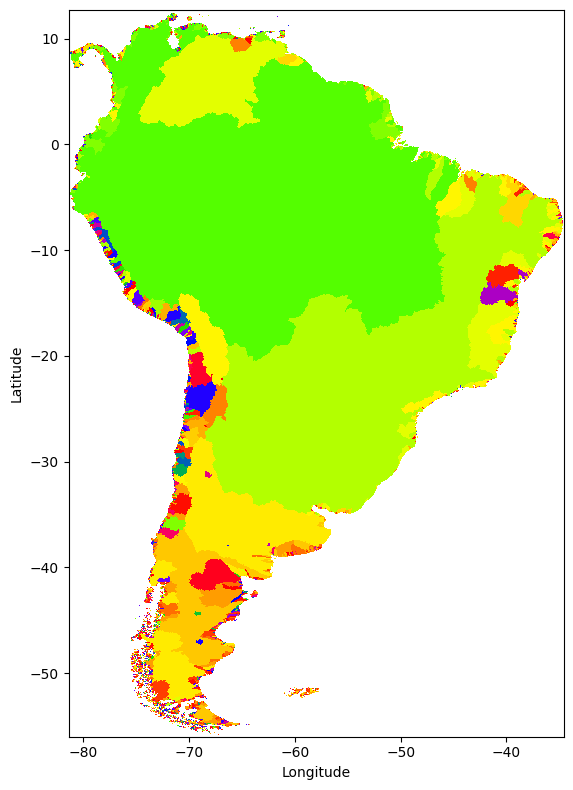

In [14]:
basins = rasterio.open("/content/lbasin_all.tif")
# Create a figure and an axes
fig, ax = plt.subplots(figsize=(8, 8))
show(basins, ax=ax, cmap='prism', interpolation='nearest')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

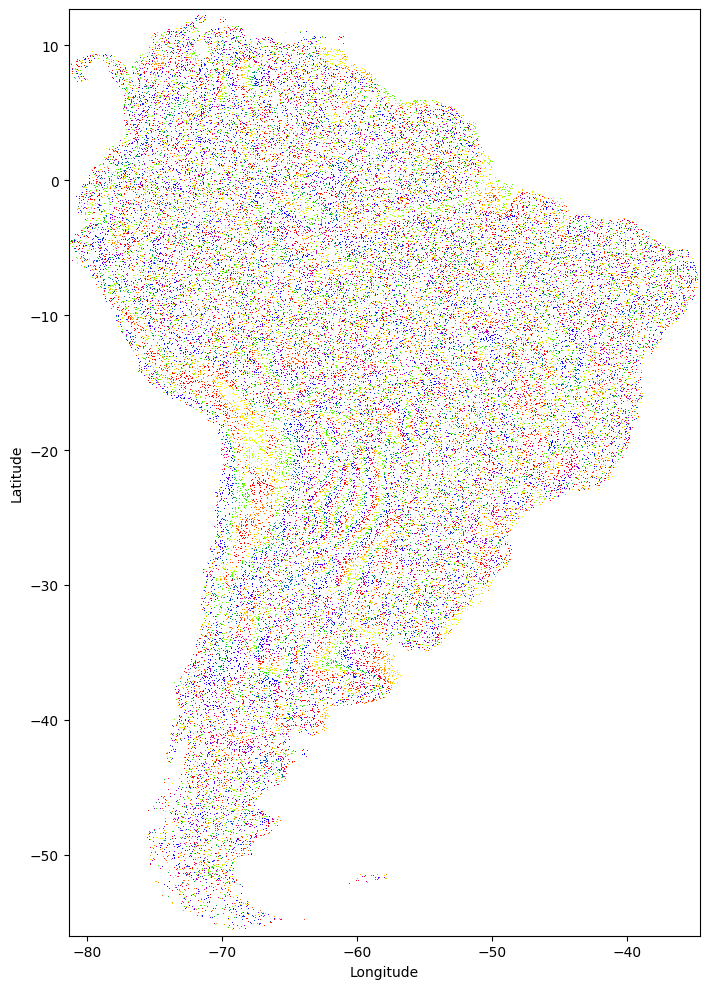

In [15]:
streams = rasterio.open("/content/stream_all.tif")
# Create a figure and an axes
fig, ax = plt.subplots(figsize=(10, 10))
show(streams, ax=ax, cmap='prism', interpolation='nearest')
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.tight_layout()
plt.show()

## Acknowledgments
This material has been developed as part of the NSF-funded POSE project TI-2303651: Growing GRASS OSE for Worldwide Access to Multidisciplinary Geospatial Analytics.